In [230]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
BASELINES = ["DBMS\n(Diff DB,Test Env)", "DBMS\n(Test DB,Test Env)"]

HUES = {}

# Base models
HUES["DBMS\n(Diff DB,Test Env)"] = "Red"  # Red is a strong color, good for contrast.
HUES["DBMS\n(Test DB,Test Env)"] = "Orange"  # Orange is distinct from red and provides good contrast.

# Your model
HUES["Factorized (Osprey)"] = "RoyalBlue"  # A bright and prominent shade of blue.
HUES["Factorized (Pre-trained MLP)"] = "DeepPink"
HUES["Factorized\n(Query History,\n No System Logs)"] = "SlateGray"

# Other GCN models
HUES["GCN\n(Test DB,Diff Env)"] = "LightGreen"  # A lighter shade for distinction from darker colors.
HUES["GCN\n(Diff DB,Test Env)"] = "Cyan"  # Cyan is visually distinct from blue and green.
HUES["GCN\n(Test DB,Test Env)"] = "LightGray"  # A neutral, unobtrusive color for the least focus.

# Factorized models
HUES["Factorized\n(No Pre-training)"] = "YellowGreen"  # A yellow-green shade for differentiation.

# GCN-Transformer models
HUES["GCN-Transformer (TestDB)"] = "SlateGray"  # A neutral color that doesn't dominate.

In [232]:
api = wandb.Api()

In [233]:
bruns = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.alg": "dbms"},
      {"$or": [
            {"$and": [
                {"tags":"single-final9-min-01-baseline"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(bruns)} runs")

Found 3 runs


In [234]:
import time
start = time.time()

bdfs = []

cur_run = None
for run in bruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        print("not finished!")
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    bdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(bdfs))

bdf = pd.concat(bdfs)
#bdf = bdf[bdf["config"] == "configs/baselines/config_dbms_imdb.yaml"]
print(len(bdf))

took:  0.011312007904052734
3
3


In [235]:
bdf[["Final-LatencyQError-test-mean", "Final-LatencyQError-test_unseen-mean", "dbms_fit_test"]]

,Final-LatencyQError-test-mean,Final-LatencyQError-test_unseen-mean,dbms_fit_test
0,18.042923,26.897645,0
0,18.042923,NaN,0
0,20.202283,17.142025,1


In [236]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 5},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
      {"$or": [
            {"$or": [
                #{"tags":"imdb-final9-ablations-logfiles"},
                {"tags": "single-final9-min-01"},
                {"tags":"ceb-env-mlp"},
                {"tags":"imdb-final9-ablations"},
                {"tags":"imdb_hist_net"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 232 runs


In [237]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  1.8376951217651367
189


In [238]:
df = pd.concat(dfs)

print(set(df["config"]))

df1 = df[df["config"].str.contains("transfer")]
df1 = df[df["feat_onehot"] == 0]
print("Num transferrable: ", len(df1))

df2 = df[(df["tags"] == "exp1_single,exp2_single,exp3_single,exp7_single_ceb2") &
            (df["split_kind"] == "lt_type-query") &
            ~(df["config"].str.contains("nopretrain"))
        ]

df3 = df[df["config"].str.contains("nopretrain")]
df3 = df3[df3["sys_net_pretrained"] == 0]

print(set(df3["seed"]))
df3 = df3.drop_duplicates(["seed"])
print(len(df3))

df = pd.concat([df1,df2, df3])

df = pd.concat([df, bdf])
print(len(df))

{'configs/evals/concurrent/config_noimdb_mt.yaml', 'configs/evals/single/config_noimdb_transferable.yaml', 'configs/evals/single/config_noimdb_cols.yaml', 'configs/evals/single/config_noimdb_nopretraining.yaml', 'configs/evals/single/config_noimdb_hist.yaml', 'configs/evals/single/config_noimdb.yaml'}
Num transferrable:  6
{1, 2, 3, 4}
4
74


In [239]:
print(set(df["alg"]))
print(set(df["config"]))

{'nn', 'dbms'}
{'configs/evals/single/config_noimdb_transferable.yaml', 'configs/evals/single/config_noimdb_cols.yaml', 'configs/evals/single/config_noimdb_nopretraining.yaml', 'configs/evals/single/config_noimdb_hist.yaml', 'configs/baselines/config_dbms_imdb.yaml', 'configs/evals/single/config_noimdb.yaml'}


In [240]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

PRETRAINED_NAME = False

def get_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    elif row["sys_net_arch"] == "mlp":
        return "Factorized (Pre-trained MLP)"
    
    elif "hist" in row["config"]:
        return "Factorized\n(Query History,\n No System Logs)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (Osprey)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_final_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    elif row["sys_net_arch"] == "mlp":
        return "Factorized (Pre-trained MLP)"
    
    elif "hist" in row["config"]:
        return "Factorized\n(Query History,\n No System Logs)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (Osprey)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_workload(row):
    if "dbms" in row["alg"].lower():
        return "IMDb"
    
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
    
    
df["Estimator"] = df.apply(lambda x: get_final_alg(x),axis=1)
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

1.0
3.0
6.0
2.0
5.0
4.0
1.0
3.0
6.0
2.0
5.0
4.0


In [241]:
df = df[df["alg"].notna()]

In [242]:
print(len(df))
print(set(df["Estimator"]))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print("pretrain: " , set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))
print(set(df["tags"]))
print(set(df["seed"]))
print(df.keys())

74
{'models4/concurrent_noimdb_logfeats_col_test099.wt', 'Factorized\n(Query History,\n No System Logs)', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'Factorized (Osprey)', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'GCN\n(Test DB,Test Env)', 'DBMS\n(Diff DB,Test Env)', 'GCN-Transformer (TestDB)', 'Factorized (Pre-trained MLP)', 'GCN\n(Test DB,Diff Env)', 'GCN\n(Diff DB,Test Env)', 'Factorized\n(No Pre-training)', 'DBMS\n(Test DB,Test Env)', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/noactual_mixed_noimdb_logfeats_col.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt'}
{1}
{0, 1, 2, 3, 4}
{'configs/evals/single/config_noimdb_transferable.yaml', 'configs/evals/single/config_noimdb_cols.yaml', 'configs/evals/single/config_noimdb_nopretraining.yaml', 'configs/evals/single/config_noimdb_hist.yaml', 'configs/baselines/config_dbms_imdb.yaml', 'configs/evals/single/config_noimdb.yaml'}
pretrain:  {'models4/concurrent_noimdb_mlp.wt', 'models4/con

In [243]:
#df = df[df["alg"] != "DBMS-all"]
#df = df[df["alg"] != "GCN-Pretrained-Latent"]

In [244]:
print(len(df))
df.keys()

74


Index(['Tags', 'name', 'lr', 'alg', 'hl1', 'arch', 'seed', 'tags', 'config',
       'min_est',
       ...
       'new_env_unseen-LatencyQError', 'test-LatencyQError', 'test-LatencyMSE',
       'train-LatencyMSE', 'train-LatencyQError', 'new_env_unseen-LatencyMSE',
       'test-LatencyRelError', 'train-LatencyRelError', 'Estimator',
       'workload'],
      dtype='object', length=258)

In [245]:
#df = df[df["weight_decay"] == 0.1]

In [246]:
pd.set_option('display.max_rows', 500)

tmp = df[df["num_instances"] == 1]
tmp[["seed", "num_instances", "alg", "extra_training", "weight_decay", "lr", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
    "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

,seed,num_instances,alg,extra_training,weight_decay,lr,Final-LatencyQError-test-mean,Final-LatencyAE-test-mean,weight_decay,Final-LatencyMSE-test-mean,Final-LatencyQError-test-median,Final-LatencyQError-test-99p
0,0,1,Factorized (Pre-trained MLP),0,1,0.00010,6.676849,66.515167,1,19761.426881,2.722839,53.921366
0,0,1,models4/concurrent_noimdb_logfeats_col_single-...,0,1,0.00010,10.080331,98.643333,1,39217.691956,3.660086,95.717359
0,0,1,models4/concurrent_noimdb_randomsplit_test99.wt,0,1,0.00010,5.902248,59.935610,1,17041.225542,2.612083,49.157034
0,0,1,models4/noactual_mixed_noimdb_logfeats_col.wt,0,1,0.00010,5.541673,64.873355,1,21555.018850,2.506550,53.217147
0,0,1,models4/concurrent_noimdb_logfeats_col_test099.wt,0,1,0.00010,5.387868,55.622836,1,15685.119407,2.526996,43.142443
0,0,1,GCN-Transformer (TestDB),0,1,0.00010,10.185368,72.295427,1,22647.060558,3.285536,97.345909
0,0,1,models4/concurrent_noimdb_logfeats_col_test05.wt,0,1,0.00010,6.413125,74.529166,1,25929.943062,2.677879,56.505228
0,0,1,"GCN\n(Test DB,Diff Env)",0,1,0.00010,6.633850,55.665791,1,12902.332990,2.810073,53.162519
0,0,1,models4/concurrent_noimdb_logfeats_col_test09.wt,0,1,0.00010,5.239281,56.594548,1,16161.163358,2.487278,43.687667
0,0,1,Factorized (Osprey),0,1,0.00010,5.410773,55.230169,1,15103.513613,2.391230,46.336498


In [247]:
print(len(df))
print(set(df["alg"]))
print(set(df["Estimator"]))

74
{'models4/concurrent_noimdb_logfeats_col_test099.wt', 'Factorized\n(Query History,\n No System Logs)', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'Factorized (Osprey)', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'GCN\n(Test DB,Test Env)', 'DBMS\n(Diff DB,Test Env)', 'GCN-Transformer (TestDB)', 'Factorized (Pre-trained MLP)', 'GCN\n(Test DB,Diff Env)', 'GCN\n(Diff DB,Test Env)', 'Factorized\n(No Pre-training)', 'DBMS\n(Test DB,Test Env)', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/noactual_mixed_noimdb_logfeats_col.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt'}
{'models4/concurrent_noimdb_logfeats_col_test099.wt', 'Factorized\n(Query History,\n No System Logs)', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'Factorized (Osprey)', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'GCN\n(Test DB,Test Env)', 'DBMS\n(Diff DB,Test Env)', 'GCN-Transformer (TestDB)', 'Factorized (Pre-trained MLP)', 'GCN\n(Test DB,Diff Env)', 'GCN\

In [248]:
#df = df[df["seed"] < 4]

In [249]:
tmp1 = df[~df["config"].str.contains("mt")]
tmp2 = df[df["config"].str.contains("mt")]

In [250]:
tmp1.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
12,models4/concurrent_noimdb_logfeats_col_test09.wt,4.0,6.235161,0.511418,5.587039,6.044623,6.261322,6.451860,6.830962
11,models4/concurrent_noimdb_logfeats_col_test05.wt,4.0,6.495519,1.277428,5.304435,5.456755,6.420555,7.459319,7.836531
4,Factorized (Osprey),10.0,6.755366,0.868139,5.773417,6.273267,6.603193,7.161102,8.692348
14,models4/concurrent_noimdb_randomsplit_test99.wt,5.0,7.434568,1.391300,5.914445,6.723296,6.746562,8.584924,9.203611
8,"GCN\n(Test DB,Test Env)",6.0,7.817048,8.497383,2.619695,4.064243,4.662072,5.727414,25.010953
15,models4/noactual_mixed_noimdb_logfeats_col.wt,4.0,8.045303,1.248473,6.966476,7.009583,7.878131,8.913850,9.458473
5,Factorized (Pre-trained MLP),5.0,9.073792,2.306981,6.577750,8.216640,8.370079,9.429037,12.775454
13,models4/concurrent_noimdb_logfeats_col_test099.wt,5.0,9.906065,6.509817,5.902796,6.884024,6.884985,8.419266,21.439255
2,Factorized\n(No Pre-training),4.0,11.332648,6.499454,7.600822,8.130044,8.330831,11.533436,21.068109
10,models4/concurrent_noimdb_logfeats_col_single-...,5.0,13.170249,5.493679,8.445021,9.533291,12.324390,13.188572,22.359972


In [251]:
tmp1[["seed", "Estimator", "Final-LatencyQError-test_unseen-mean"]]

,seed,Estimator,Final-LatencyQError-test_unseen-mean
0,1,"GCN\n(Diff DB,Test Env)",14.270483
0,1,"GCN\n(Diff DB,Test Env)",16.558094
0,1,"GCN\n(Diff DB,Test Env)",14.482428
0,1,"GCN\n(Diff DB,Test Env)",14.415301
0,1,"GCN\n(Diff DB,Test Env)",13.933278
0,1,"GCN\n(Diff DB,Test Env)",14.318700
0,2,"Factorized\n(Query History,\n No System Logs)",16.269406
0,4,"Factorized\n(Query History,\n No System Logs)",10.521029
0,1,"Factorized\n(Query History,\n No System Logs)",33.907532
0,3,"Factorized\n(Query History,\n No System Logs)",9.805001


In [252]:
tmp2.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,index,count,mean,std,min,25%,50%,75%,max


In [253]:
FN_TMP = "NewInstances-{}-{}.pdf"

def plot_metrics(data, metric_median, metric_90p, metric_mean, title, prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    
    # Filter out the baseline data from the data being plotted
    data = data[data['alg'] != "DBMS (instance-tuned)"]
    
    if "MSE" in metric_mean:
        use_log = True
    else:
        use_log = False
    
    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    # Plot for Median values
    sns.barplot(data=data, y=metric_median, x="num_instances", hue="Estimator", dodge=True, ax=axs[0])
    if baseline_median is not None:
        axs[0].axhline(baseline_median, color='r', linestyle='--', label='Baseline (Median)')
    axs[0].set_title('Median')

    if use_log:
        axs[0].set_yscale("log")
        
        
    # Plot for 90th Percentile values
    sns.barplot(data=data, y=metric_90p, x="num_instances", hue="Estimator", dodge=True, ax=axs[1])
    if baseline_median is not None:
        axs[1].axhline(baseline_90p, color='r', linestyle='--', label='Baseline (90th Percentile)')
    axs[1].set_title('90th Percentile')
    #if should_use_log_scale(data[metric_90p]):
        
    if use_log:
        axs[1].set_yscale("log")

    # Plot for Mean values
    sns.barplot(data=data, y=metric_mean, x="num_instances", hue="Estimator", dodge=True, ax=axs[2])
    if baseline_median is not None:
        axs[2].axhline(baseline_mean, color='r', linestyle='--', label='Baseline (Mean)')
        
    axs[2].set_title('Mean')
    if use_log:
        axs[2].set_yscale("log")


    # Remove individual legends and add a single legend at the top
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.10), ncol=3)

    # Finalize the plot and save
    plt.tight_layout()
    fn = FN_TMP.format(prefix + "IMDb", title.replace(' ', '-'))
    print(fn)
    plt.savefig(fn, bbox_inches="tight")


In [254]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test-median', 
#              'Final-LatencyMSE-test-90p', 
#              'Final-LatencyMSE-test-mean',
#              'Latency MSE', 
#              prefix="SeenQ-")

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test-median', 
#              'Final-LatencyQError-test-90p', 
#              'Final-LatencyQError-test-mean',
#              'Latency Q-Error',
#               prefix="SeenQ-")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test-median', 
#              'Final-LatencyRelError-test-90p', 
#              'Final-LatencyRelError-test-mean',
#              'Latency Relative Error',
#              prefix="SeenQ-")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test-median', 
#              'Final-LatencyAE-test-90p', 
#              'Final-LatencyAE-test-mean',
#              'Latency Absolute Error',
#               prefix="SeenQ-")


In [255]:
tmp = df
# Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test_unseen-median', 
#              'Final-LatencyMSE-test_unseen-90p', 
#              'Final-LatencyMSE-test_unseen-mean',
#              'Latency MSE',
#              prefix="UnseenQ")
    

# Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test_unseen-median', 
#              'Final-LatencyQError-test_unseen-90p', 
#              'Final-LatencyQError-test_unseen-mean',
#              'Latency Q-Error',
#                  prefix="UnseenQ")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test_unseen-median', 
#              'Final-LatencyRelError-test_unseen-90p', 
#              'Final-LatencyRelError-test_unseen-mean',
#              'Latency Relative Error',
#                     prefix="UnseenQ")

# Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test_unseen-median', 
#              'Final-LatencyAE-test_unseen-90p', 
#              'Final-LatencyAE-test_unseen-mean',
#              'Latency Absolute Error',
#                  prefix="UnseenQ")


In [256]:
# print(set(df["only_workload"]))

# WKS = ["ssb", "ccs", "accidents", "airline"]
# fig,axs = plt.subplots(nrows=1,ncols=4, figsize=(12,5))

# for wi,wk in enumerate(WKS):
#     ax = axs[wi]
#     tmp = df[df["only_workload"] == wk]
#     sns.barplot(data=tmp, x="alg", y='Final-LatencyQError-test_unseen-mean', 
#                 hue="alg", 
#                 dodge=False, ax=ax)
#     ax.legend().remove()

27


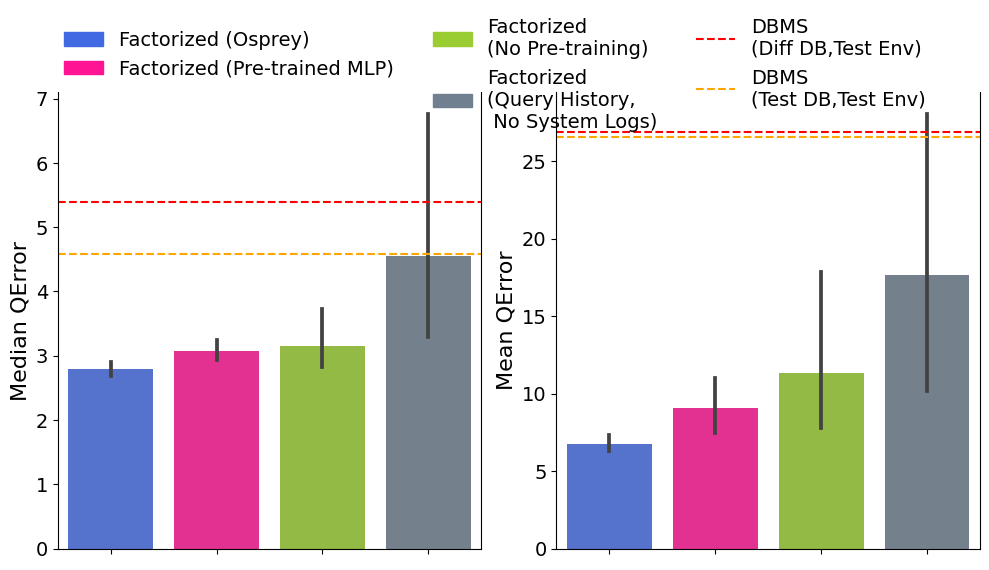

In [257]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

ORDER = ["Factorized (Osprey)", "Factorized (Pre-trained MLP)", "Factorized\n(No Pre-training)", 
         "Factorized\n(Query History,\n No System Logs)",
        ]

# Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

tmp = df[df["Estimator"].isin(ORDER+BASELINES)]
print(len(tmp))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# First subplot
ax = axs[0]

# Plot the bars
sns.barplot(data=tmp, x="Estimator", 
            y='Final-LatencyQError-test_unseen-median', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

# Baseline lines
baseline_handles = []
for estb in BASELINES:
    tmp2 = tmp[tmp["Estimator"] == estb]
    if len(tmp2) == 0:
        continue
    bmedian = tmp2['Final-LatencyQError-test_unseen-median'].mean()
    line = ax.axhline(bmedian, color=HUES[estb], linestyle='--')
    baseline_handles.append(line)

ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("Median QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks
#ax.set_ylim([1, 10])

ax.legend().remove()  # Remove the auto-generated legend
ax.spines['top'].set_visible(False) 

# Second subplot
ax = axs[1]

sns.barplot(data=tmp, x="Estimator", 
            y='Final-LatencyQError-test_unseen-mean', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("Mean QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

for estb in BASELINES:
    tmp2 = tmp[tmp["Estimator"] == estb]
    if len(tmp2) == 0:
        continue
    bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
    ax.axhline(bmean, color=HUES[estb], linestyle='--')
    
ax.spines['top'].set_visible(False) 
    
#ax.set_ylim([1, 50])

ax.legend().remove()  # Remove the auto-generated legend

# Manually create the legend
if baseline_handles:
    custom_handles = bar_handles + baseline_handles 
    custom_labels = ORDER + BASELINES
else:
    custom_handles = bar_handles
    custom_labels = ORDER

fig.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper center', 
           fontsize=14,
           ncol=3, 
           bbox_to_anchor=(0.5, 1.15),
           frameon=False)

plt.tight_layout()
plt.savefig("EvalSingle-IMDb.pdf", bbox_inches="tight")

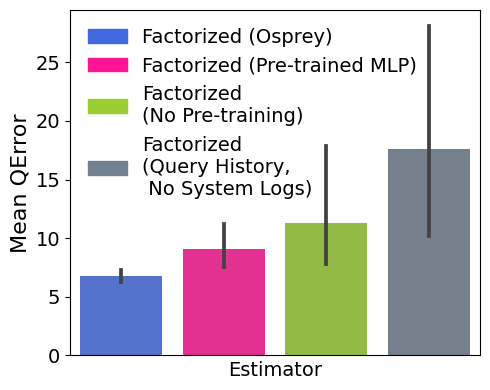

In [258]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

#ORDER = ["Factorized (Osprey)", "Factorized (Pre-trained MLP)", "Factorized\n(No Pre-training)"]

ORDER = ["Factorized (Osprey)", "Factorized (Pre-trained MLP)", "Factorized\n(No Pre-training)", 
         "Factorized\n(Query History,\n No System Logs)",
        ]

# Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

tmp = df[df["Estimator"].isin(ORDER)]

# Create the plot
plt.figure(figsize=(5, 4))  # Adjust the size as needed
ax = plt.gca()

# Plot the bars
sns.barplot(data=tmp, x="Estimator", 
            y='Final-LatencyQError-test_unseen-mean', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

# Baseline lines
baseline_handles = []
for estb in BASELINES:
    tmp2 = tmp[tmp["Estimator"] == estb]
    if len(tmp2) == 0:
        continue
    bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
    line = ax.axhline(bmean, color=HUES[estb], linestyle='--')
    baseline_handles.append(line)

    
ax.set_ylabel("Mean QError", fontsize=16)
ax.tick_params(axis='x', length=0)  # Removing x-axis ticks
ax.set_xticks([])
ax.set_xlabel("Estimator", fontsize=14)  # Removing the x-axis label
ax.tick_params(axis='y', labelsize=14)


#ax.spines['top'].set_visible(False)

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# Combine custom handles
custom_handles = bar_handles + baseline_handles 
custom_labels = ORDER

# Create the legend
ax.legend(handles=custom_handles, labels=custom_labels, 
          fontsize=14, loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig("Eval-Architectures-IMDb.pdf", bbox_inches="tight")
plt.show()

In [259]:
set(df["Estimator"])

{'DBMS\n(Diff DB,Test Env)',
 'DBMS\n(Test DB,Test Env)',
 'Factorized\n(No Pre-training)',
 'Factorized\n(Query History,\n No System Logs)',
 'Factorized (Osprey)',
 'Factorized (Pre-trained MLP)',
 'GCN\n(Diff DB,Test Env)',
 'GCN\n(Test DB,Diff Env)',
 'GCN\n(Test DB,Test Env)',
 'GCN-Transformer (TestDB)',
 'models4/concurrent_noimdb_logfeats_col_single-instance.wt',
 'models4/concurrent_noimdb_logfeats_col_test05.wt',
 'models4/concurrent_noimdb_logfeats_col_test09.wt',
 'models4/concurrent_noimdb_logfeats_col_test099.wt',
 'models4/concurrent_noimdb_randomsplit_test99.wt',
 'models4/noactual_mixed_noimdb_logfeats_col.wt'}

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

FN_TMP = "NewInstances-{}-{}.pdf"

# Define a function to check if the values have a large range and should be plotted in log scale
def should_use_log_scale(values):
    return max(values) / min(values) > 1000  # Adjust this threshold if needed
    
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics2(data, metric_median, metric_90p, metric_mean, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    # Filter out the baseline data
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    #data = data[data['alg'] != "DBMS (instance-tuned)"]

    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    metrics = [(metric_median, baseline_median, 'Median'),
               (metric_90p, baseline_90p, '90th Percentile'),
               (metric_mean, baseline_mean, 'Mean')]

    algs = data['alg'].unique()
    colors = sns.color_palette("tab10", len(algs))
    alg_color_map = dict(zip(algs, colors))
    
    bar_width = 0.15
    num_algs = len(algs)
    positions = list(range(len(data['num_instances'].unique())))

    for i, (metric, baseline, metric_name) in enumerate(metrics):
        ax = axs[i]
        for j, alg in enumerate(algs):
            alg_data = data[data['alg'] == alg]
            
            # Positional adjustments for the bars based on their order
            pos = [p + j * bar_width for p in positions]
            
            mean_values = alg_data.groupby("num_instances")[metric].mean()
            min_values = alg_data.groupby("num_instances")[metric].min()
            max_values = alg_data.groupby("num_instances")[metric].max()
            yerr = [mean_values - min_values, max_values - mean_values]
            
            ax.bar(pos, mean_values, bar_width, yerr=yerr, align='center',
                   alpha=0.7, ecolor='black', capsize=10, label=alg, color=alg_color_map[alg])

        if baseline is not None:
            ax.axhline(baseline, color='r', linestyle='--', label='Baseline ({})'.format(metric_name))
        
        ax.set_title(metric_name)
        ax.set_xlabel('Number of Instances')
        ax.set_ylabel(title)
        ax.yaxis.grid(True)
        ax.set_xticks([p + bar_width * (num_algs-1)/2 for p in positions])
        ax.set_xticklabels([1, 2, 3, 4])

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=(len(handles) + 1) // 3)
    
    plt.tight_layout()
    fn = FN_TMP.format("IMDb", title.replace(' ', '-'))
    #plt.savefig(fn, bbox_inches="tight")


# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    


NewInstances-IMDb-Latency-MSE.pdf
NewInstances-IMDb-Latency-Q-Error.pdf
NewInstances-IMDb-Latency-Relative-Error.pdf
NewInstances-IMDb-Latency-Absolute-Error.pdf


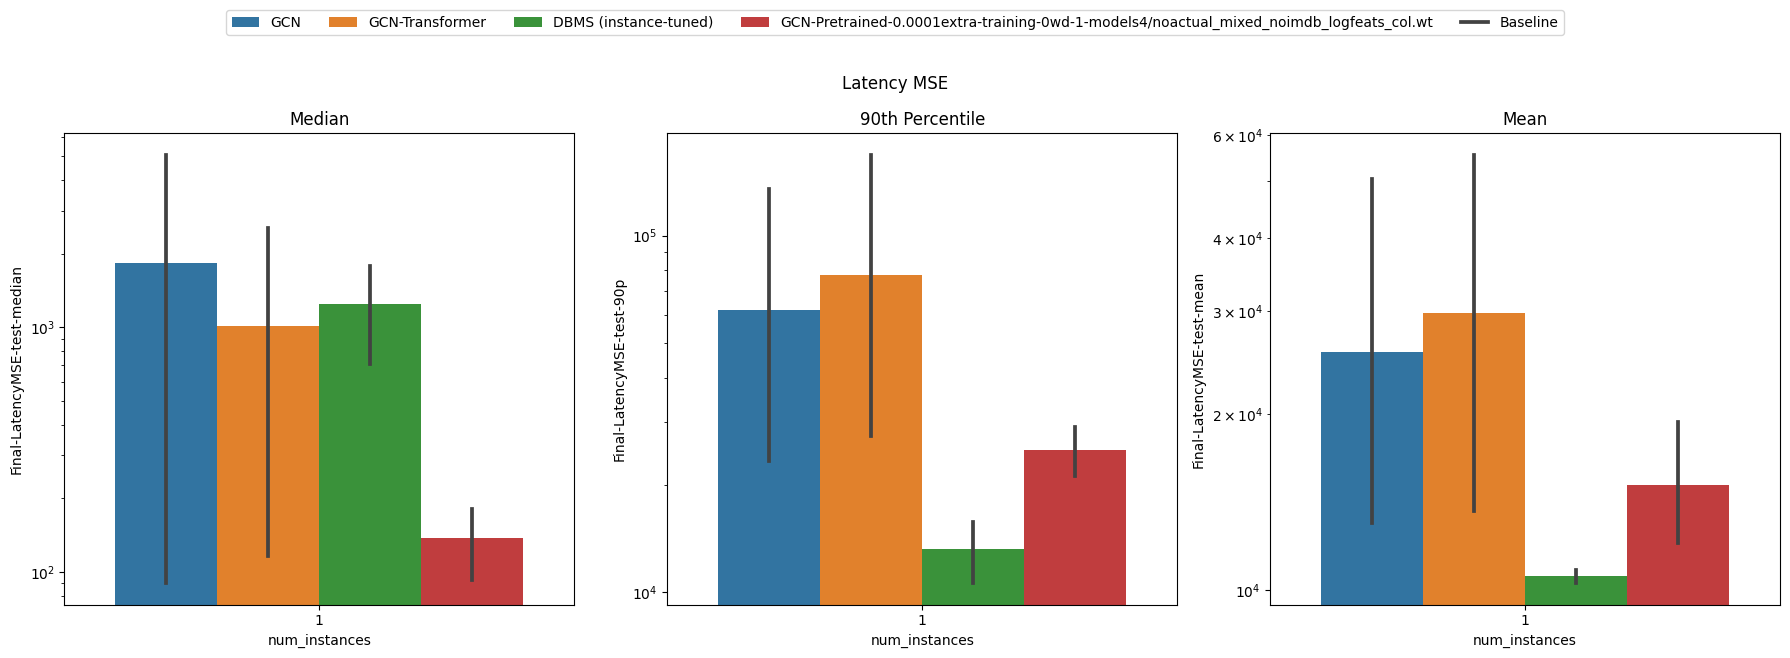

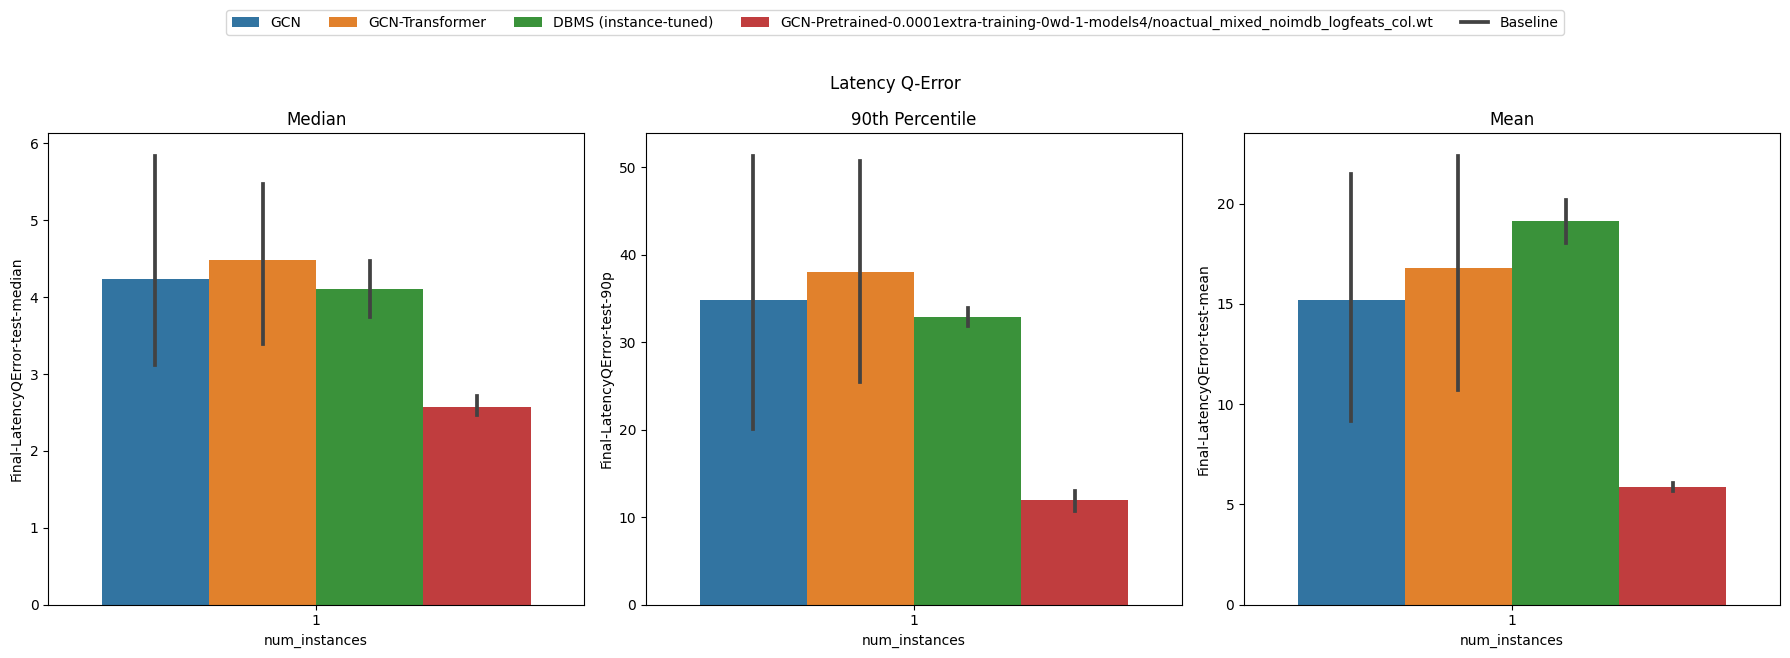

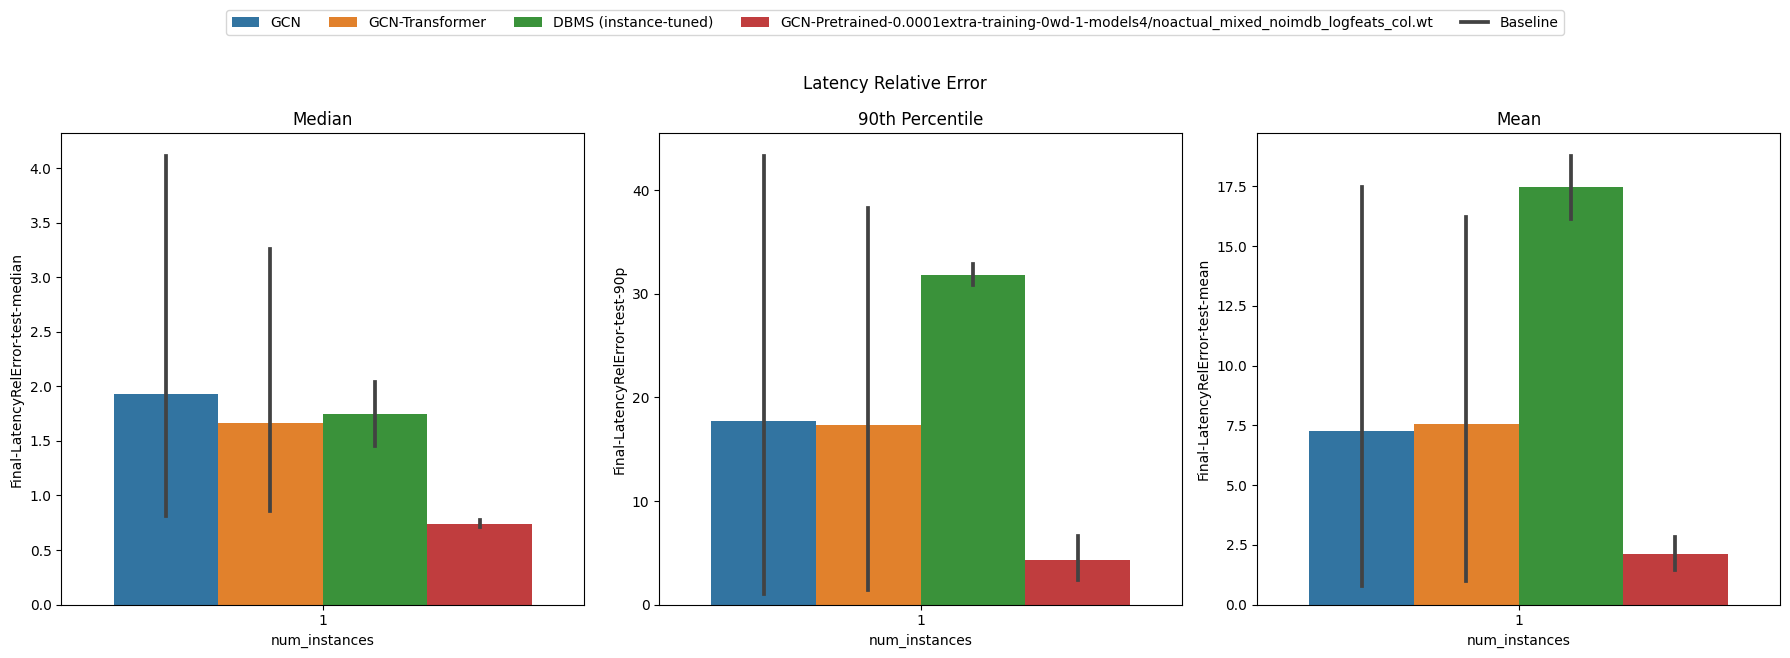

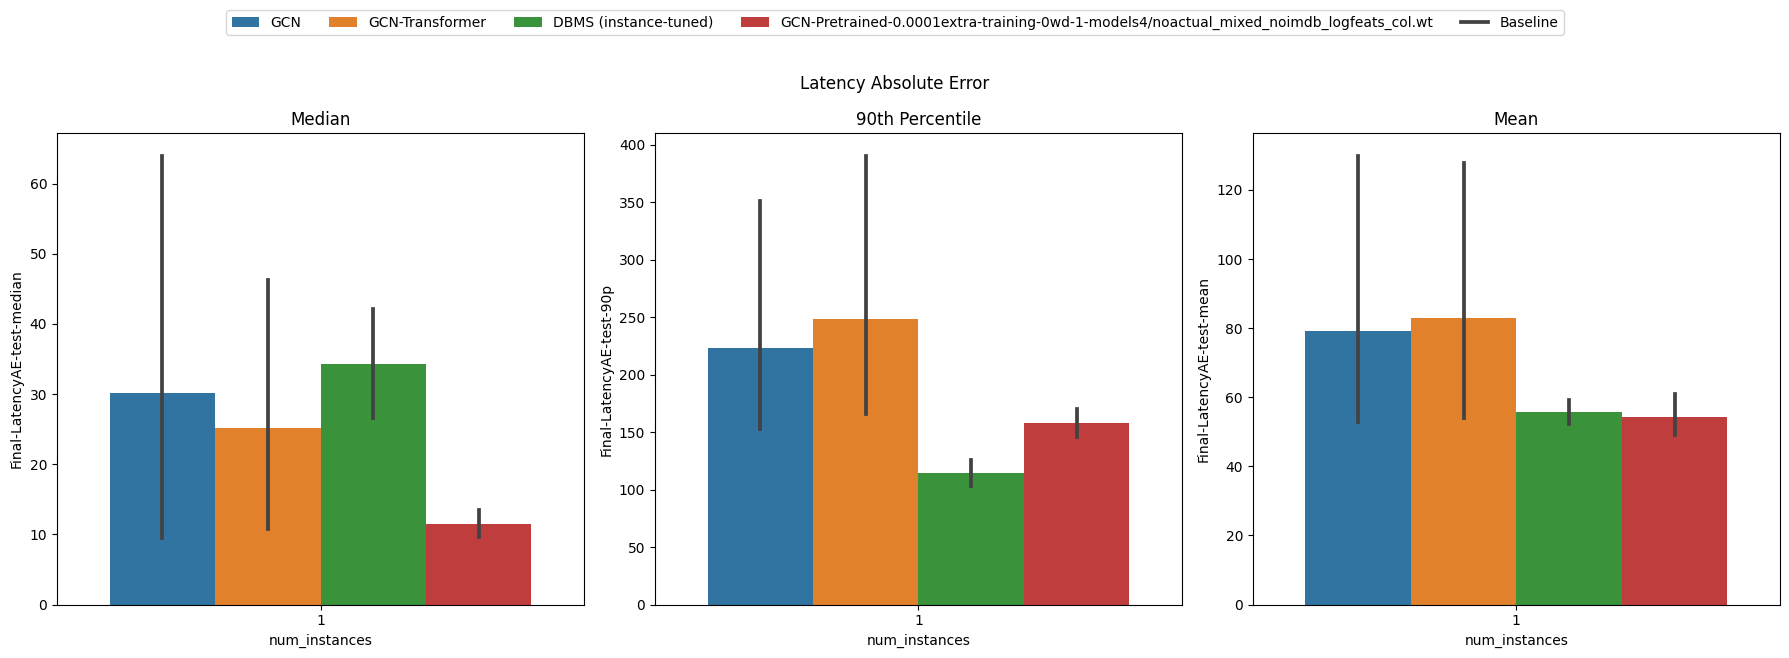

In [81]:

    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


ValueError: Could not interpret input 'Final-LatencyMSE-test_useen-median'

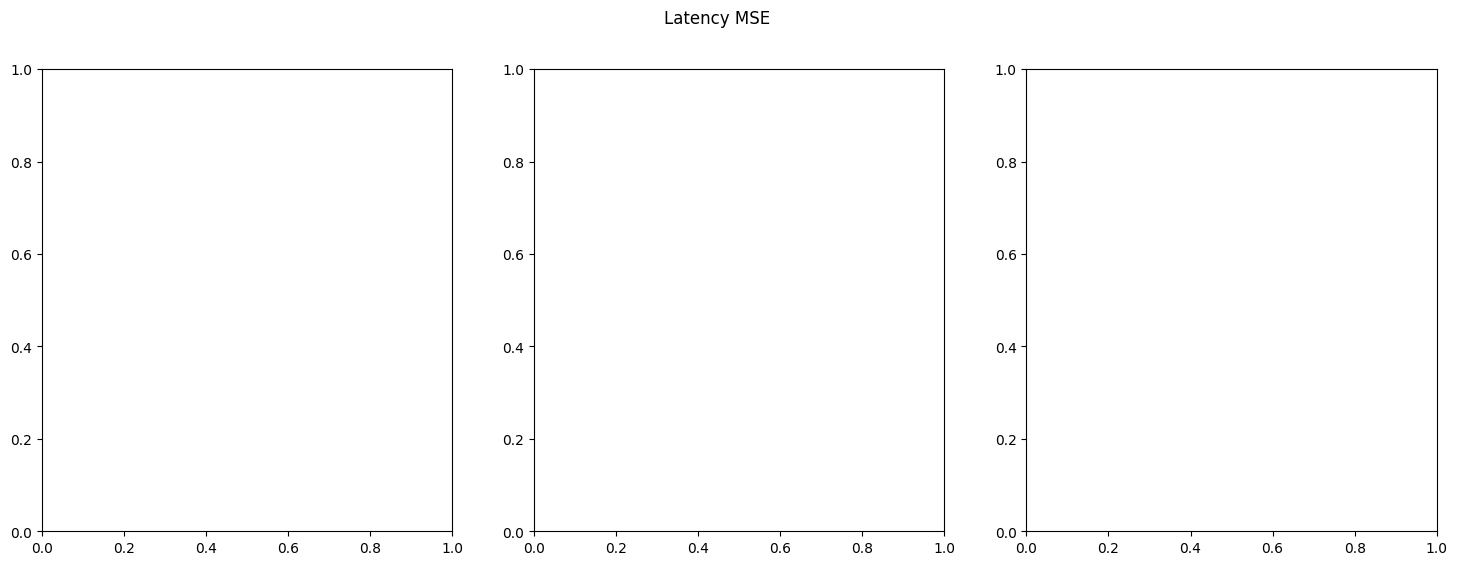

In [82]:
# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test_useen-median', 
             'Final-LatencyMSE-test_useen-90p', 
             'Final-LatencyMSE-test_useen-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test_useen-median', 
             'Final-LatencyQError-test_useen-90p', 
             'Final-LatencyQError-test_useen-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test_useen-median', 
             'Final-LatencyRelError-test_useen-90p', 
             'Final-LatencyRelError-test_useen-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test_useen-median', 
             'Final-LatencyAE-test_useen-90p', 
             'Final-LatencyAE-test_useen-mean',
             'Latency Absolute Error')


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (4).

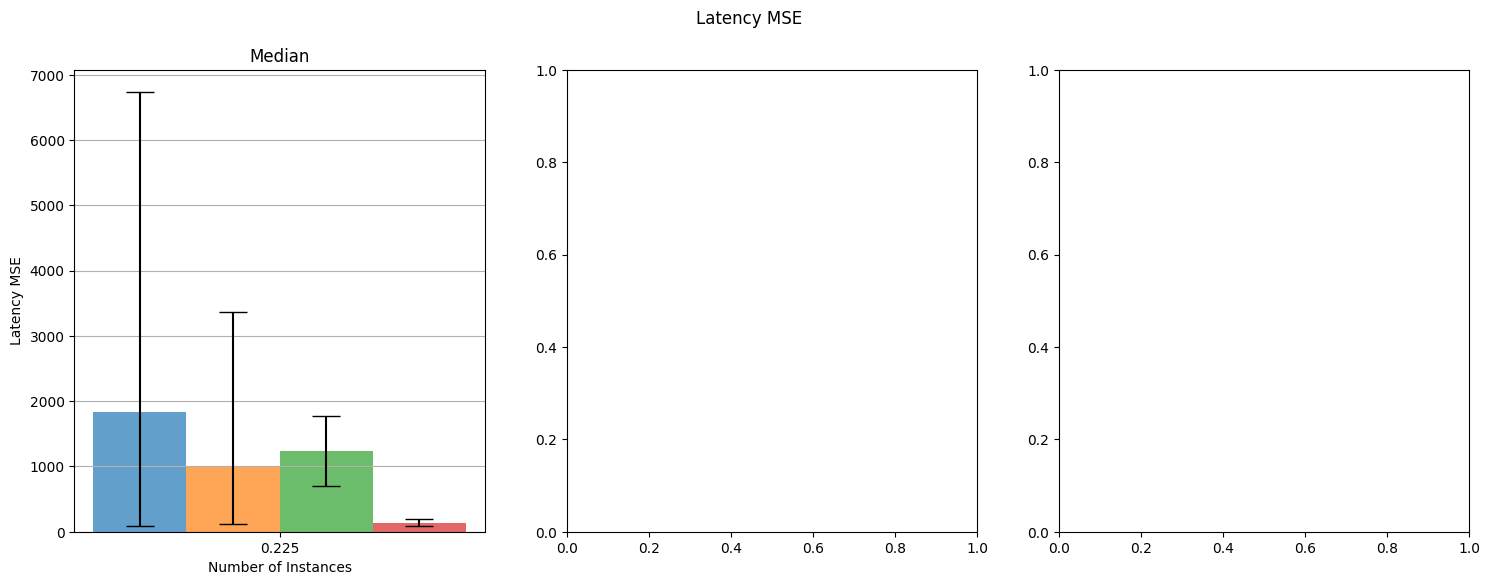

In [83]:
# Plot for MSE
plot_metrics2(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics2(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics2(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics2(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data for 3 baselines and 5 seeds for each baseline
# baseline_names = ["Baseline1", "Baseline2", "Baseline3"]
# baseline_data = {
#     "Baseline1": [[5, 5.1, 5.8], [5.5, 5.6, 6.1], [6, 6.2, 6.7], [6.1, 6.3, 6.8], [5.9, 6.0, 6.4]],  # Each inner list has [mean, median, 90p]
#     "Baseline2": [[6, 6.1, 6.8], [6.4, 6.5, 7], [6.7, 6.8, 7.3], [6.3, 6.4, 7], [6.1, 6.2, 6.9]],
#     "Baseline3": [[7, 7.1, 7.8], [7.2, 7.3, 8], [7.4, 7.5, 8.2], [7.1, 7.3, 8], [7.2, 7.4, 7.9]]
# }

# means = [np.mean([seed[0] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# medians = [np.mean([seed[1] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# p90s = [np.mean([seed[2] for seed in baseline_data[baseline]]) for baseline in baseline_names]

# # Create bars for means
# bars = plt.bar(baseline_names, means, color='lightblue', label='Mean')

# # Add median points on the bars
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, medians[i] + 0.1, 'x', ha='center', va='bottom', color='black', fontsize=12, label='Median' if i==0 else "")

# # Add error bars to represent up to the 90p
# plt.errorbar(baseline_names, means, [0]*len(means), [p90 - mean for p90, mean in zip(p90s, means)], fmt='none', ecolor='red', capsize=5, label='90th Percentile')

# plt.ylabel('Value')
# plt.title('Metrics across different baselines')
# plt.legend()
# plt.show()

In [250]:
df[df['alg'] == "DBMS (instance-tuned)"]

,Tags,name,lr,alg,hl1,arch,seed,tags,config,min_est,...,Final-LatencyQError-train-median,Final-LatencyMSE-train-90p,Final-LatencyMSE-test-median,Final-LatencyQError-train-90p,Final-LatencyRelError-test-99p,Final-LatencyRelError-train-median,Final-LatencyAE-train-90p,Final-LatencyMSE-train-mean,test_query_dir,workload
0,"[3a, final5-fixed_instances-min-1]",icy-waterfall-4116,0.00001,DBMS (instance-tuned),512,factorized,1,"exp10_single_zdbs,exp5_single_stats,exp8_singl...",configs/baselines/config_dbms_imdb.yaml,None,...,9.928848,737.231749,179.031049,18.463977,16.435893,8.888694,27.152012,4795.967726,"./queries/ceb-small,./queries/job",Stack


In [178]:
set(df["alg"])

{'DBMS (instance-tuned)',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-0.0001extra-training-1wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-1e-05extra-training-0wd-0.1-models4/tpch-ergast-stack_actual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/tpch-ergast-stack_actual.wt'}

In [179]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# FN_TMP = "{}-{}.pdf"

# # Define a function to check if the values have a large range and should be plotted in log scale
# def should_use_log_scale(values):
#     return max(values) / min(values) > 100  # Adjust this threshold if needed

# # Define a function to plot the given metrics
# def plot_metrics(data, metric_median, metric_90p, metric_mean, title):
#     fig, axs = plt.subplots(1, 3, figsize=(18,6))
#     plt.suptitle(title)
    
#     # Plot for Median values
#     sns.barplot(data=data, y=metric_median, x="num_instances", hue="alg", dodge=True, ax=axs[0], palette=HUES)
#     axs[0].set_title('Median')
#     if should_use_log_scale(data[metric_median]):
#         axs[0].set_yscale("log")

#     # Plot for 90th Percentile values
#     sns.barplot(data=data, y=metric_90p, x="num_instances", hue="alg", dodge=True, ax=axs[1], palette=HUES)
#     axs[1].set_title('90th Percentile')
#     if should_use_log_scale(data[metric_90p]):
#         axs[1].set_yscale("log")

#     # Plot for Mean values
#     sns.barplot(data=data, y=metric_mean, x="num_instances", hue="alg", dodge=True, ax=axs[2], palette=HUES)
#     axs[2].set_title('Mean')
    
#     if should_use_log_scale(data[metric_mean]):
#         axs[2].set_yscale("log")

#     # Remove individual legends and add a single legend at the top
#     for ax in axs:
#         ax.get_legend().remove()
#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(handles))

#     # Finalize the plot and save
#     plt.tight_layout()
#     fn = FN_TMP.format(wk, title.replace(' ', '-'))
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

# # Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
#     # Plot for MSE
#     plot_metrics(tmp, 
#                  'Final-LatencyMSE-test-median', 
#                  'Final-LatencyMSE-test-90p', 
#                  'Final-LatencyMSE-test-mean',
#                  'Latency MSE')

#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyQError-test-median', 
#                  'Final-LatencyQError-test-90p', 
#                  'Final-LatencyQError-test-mean',
#                  'Latency Q-Error')

    
#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyRelError-test-median', 
#                  'Final-LatencyRelError-test-90p', 
#                  'Final-LatencyRelError-test-mean',
#                  'Latency Relative Error')
    
#     # Plot for AE
#     plot_metrics(tmp, 
#                  'Final-LatencyAE-test-median', 
#                  'Final-LatencyAE-test-90p', 
#                  'Final-LatencyAE-test-mean',
#                  'Latency Absolute Error')

In [180]:
# FN_TMP = "{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="ci"
#     TO_PLOT = ['Final-LatencyAE-test-median', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, 
#                 palette=HUES)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)

#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
#                 errorbar=EB, palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     ## train
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                palette=HUES)
#     #axs[0].legend().remove()
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
#                palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

In [106]:
# FN_TMP = "Test-{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="sd"
#     TO_PLOT = ['Final-LatencyAE-train-mean', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#     ## train
# #     ax = axs[0]
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
# #                 ax=ax, errorbar=EB, palette=HUES)
# #     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                        frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=ax, 
#                 errorbar=EB, palette=HUES)
#     #axs[1].legend().remove()
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency AE", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    
#     ## train
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
# #                palette=HUES)
#     #axs[0].legend().remove()
# #     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs, errorbar=EB,
#                palette=HUES)
    
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency Rel-Error", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     #axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")